# Exploratory Data Analysis of US RCC Dataset

## Imports

In [45]:
import tensorflow as tf
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import sklearn
import plotly.graph_objects as go
import plotly.express as px
from time import time
import json
%matplotlib inline

## Load dataset

<Axes: >

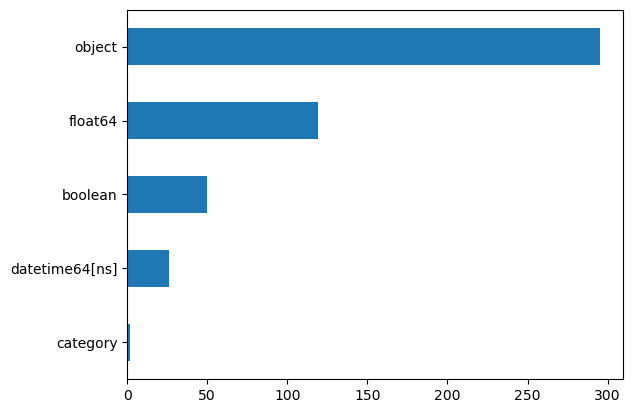

In [46]:
rcc = pd.read_pickle('../Data Sources/Cleaned/US_RCC_Database_CLEANED.pkl')
# Check to make sure dtypes persisted
rcc.dtypes.value_counts().sort_values().plot(kind = 'barh')

## TODO: Visualization w/ Alluvial Diagrams

Ultimate goal is to forecast treatment paths at an individual level using a NN. Here, we will demonstrate what this looks like at the population level. 
* Begin with anastomotic leak as end goal
* Break up path along stages of treatment
* We can take a stepwise regression/decision tree approach to add the most 'descriminant' features one at a time. Couple w/ statistical tests and display significance on chart
* Need to handle different dtypes
    * Treat num vals as parallel sets
    * NaNs as own cat
    * Might need to break up chemo regimens along y-axis

### Reproduce Ali et. al. (2024) findings on OFP -> Leak

Num samples: 825

Independent Variable:
Omental Flap to Pelvis
no     722
yes    103
Name: count, dtype: int64

Dependent Variable:
Anastomotic Leak
no     446
NaN    338
yes     41
Name: count, dtype: int64

Summary of selected demographic stats:


array([[<Axes: xlabel='Age', ylabel='Age'>,
        <Axes: xlabel='Height (cm)', ylabel='Age'>,
        <Axes: xlabel='Weight (kg)', ylabel='Age'>,
        <Axes: xlabel='BMI', ylabel='Age'>],
       [<Axes: xlabel='Age', ylabel='Height (cm)'>,
        <Axes: xlabel='Height (cm)', ylabel='Height (cm)'>,
        <Axes: xlabel='Weight (kg)', ylabel='Height (cm)'>,
        <Axes: xlabel='BMI', ylabel='Height (cm)'>],
       [<Axes: xlabel='Age', ylabel='Weight (kg)'>,
        <Axes: xlabel='Height (cm)', ylabel='Weight (kg)'>,
        <Axes: xlabel='Weight (kg)', ylabel='Weight (kg)'>,
        <Axes: xlabel='BMI', ylabel='Weight (kg)'>],
       [<Axes: xlabel='Age', ylabel='BMI'>,
        <Axes: xlabel='Height (cm)', ylabel='BMI'>,
        <Axes: xlabel='Weight (kg)', ylabel='BMI'>,
        <Axes: xlabel='BMI', ylabel='BMI'>]], dtype=object)

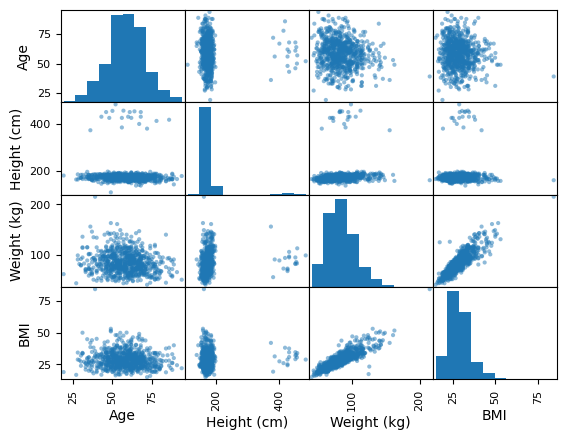

In [47]:
# Include patients w/ LAR and non-missing OFP data
leak_mvp = rcc[(rcc['Type of Operation of Rectal Tumor'] == 'lar') & rcc['Omental Flap to Pelvis'].notna()]

# Generate some summary stats
print("Num samples:", len(leak_mvp))
print("\nIndependent Variable:")
print(leak_mvp['Omental Flap to Pelvis'].value_counts(dropna=False))
print("\nDependent Variable:")
print(leak_mvp['Anastomotic Leak'].value_counts(dropna=False))
print("\nSummary of selected demographic stats:")
demo_feats = [  'Gender',
                'Age',
                'Race',
                'Height (cm)',
                'Weight (kg)',
                'BMI',
                'Health Insurance',
                'ASA Class',
                'Functional Status',
                'Family history of CRC',
                'Date of Diagnosis',
                'Primary v. Recurrence',
                'Omental Flap to Pelvis',
                'Anastomotic Leak']
pd.plotting.scatter_matrix(leak_mvp[demo_feats])

In [48]:
# For each feature of interest, connect unique values to the unique values of the previous feature.
# Set weight by proportional frequency
feats = ['Gender', 'Bowel Obstruction', 'Diabetes', 'Neoadjuvant Chemoradiation', 'Operative Approach', 'Omental Flap to Pelvis', 'Anastomotic Leak']
response = 'Anastomotic Leak'

labels = []
sources = []
targets = []
values = []
p_values = []

val_counts = []
for i, feat in enumerate(feats):
    val_counts.append(leak_mvp[feat].value_counts(dropna=False).sort_values(ascending=False))
    unique_vals = list(val_counts[i].index)
    labels.extend([feat + ': ' + str(val) for val in unique_vals])
    if (feat is not response):
        contingency_tab = pd.crosstab(leak_mvp[feat], leak_mvp[response], margins=False, dropna=False)
    if (i > 0):
        prior_unique_vals = list(val_counts[i - 1].index)
        for j, value in enumerate(unique_vals):
            for k, prior_value in enumerate(prior_unique_vals):
                # Count num samples with both values
                if (isinstance(value, float) and np.isnan(value)): 
                    value_mask = leak_mvp[feat].isna()
                else: value_mask = leak_mvp[feat] == value
                
                if (isinstance(prior_value, float) and np.isnan(prior_value)): 
                    prior_value_mask = leak_mvp[feats[i-1]].isna()
                else: prior_value_mask = leak_mvp[feats[i-1]] == prior_value

                values.append(len(leak_mvp[(value_mask) & (prior_value_mask)]) / len(leak_mvp))
                # Set source: index labels by -1 * (len(val_counts) + len(prior_val_counts) - k)
                sources.append(labels.index(labels[-1 * (len(unique_vals) + len(prior_unique_vals) - k)]))
                # Set target: index labels by -1 * (len(val_counts) - j)
                targets.append(labels.index(labels[-1 * (len(unique_vals) - j)]))

In [49]:
print(labels)
print(sources)
print(targets)
print(values)
sum(values)

['Gender: male', 'Gender: female', 'Gender: nan', 'Bowel Obstruction: nan', 'Bowel Obstruction: large bowel obstruction', 'Bowel Obstruction: partial small bowel obstruction', 'Diabetes: no', 'Diabetes: yes', 'Diabetes: nan', 'Neoadjuvant Chemoradiation: yes', 'Neoadjuvant Chemoradiation: no', 'Neoadjuvant Chemoradiation: nan', 'Operative Approach: hand-assist', 'Operative Approach: open', 'Operative Approach: laparoscopic', 'Operative Approach: hybrid', 'Operative Approach: robotic', 'Operative Approach: conversion to open', 'Operative Approach: nan', 'Operative Approach: not applicable', 'Omental Flap to Pelvis: no', 'Omental Flap to Pelvis: yes', 'Anastomotic Leak: no', 'Anastomotic Leak: nan', 'Anastomotic Leak: yes']
[0, 1, 2, 0, 1, 2, 0, 1, 2, 3, 4, 5, 3, 4, 5, 3, 4, 5, 6, 7, 8, 6, 7, 8, 6, 7, 8, 9, 10, 11, 9, 10, 11, 9, 10, 11, 9, 10, 11, 9, 10, 11, 9, 10, 11, 9, 10, 11, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 20, 21, 20, 21]
[3, 3, 3, 

6.000000000000001

In [50]:
# Create sankey/alluvial diagram
# Load color dict
with open('../Data Sources/Cleaned/color_dict.json') as fp:
  color_dict = json.load(fp)

fig = go.Figure(data=[go.Sankey(
  valueformat = ".2%",
  node = dict(
    pad = 15,
    thickness = 20,
    line = dict(color = "black", width = 0.5),
    label = labels,
    color = [color_dict[label.split(':')[0]] for label in labels]
  ),
  link = dict(
    source = sources, # indices correspond to labels, eg A1, A2, A1, B1, ...
    target = targets,
    value = values
  ))])

fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)
fig.show()

### Improvements
* Build ML model (MLR, SVM, DT) with features and report result
* $\chi^2$ test for proportions for each feature w.r.t. final output, next feature
* Handle continuous variables in a parallel plot-eske manner
* Selecting a feature filters for only that value

## Sequential Feature Selection
Proof of concept using only discrete features to visualize with Sankey

### Simple Preprocessing
1. Omit numeric dtypes, cast all others to obj
1. Take out labels, impute missing w/ 'no'
1. Create transformation pipeline:
1. For obj w/ <= 3 unique vals, one-hot enc
1. For all other obj, target encode

In [19]:
leak = leak_mvp.select_dtypes(exclude = ['float64', 'datetime64[ns]'])
leak = leak.astype('category')
leak = leak.drop(['Database ID', 'COMMENTS'], axis=1)

In [20]:
labels = leak['Anastomotic Leak'].copy().fillna('no')
leak = leak.drop('Anastomotic Leak', axis=1)
labels = pd.to_numeric(labels.replace({'yes': 1.0, 'no': 0.0}))

In [21]:
sparse_attribs = [col for col in leak.columns.to_list() if leak[col].nunique(dropna=False) < 4]

dense_attribs = leak.drop(sparse_attribs, axis=1).columns.to_list()

In [22]:
from sklearn.model_selection import train_test_split
leak_train, leak_test, labels_train, labels_test = train_test_split(leak, labels, test_size=0.1, random_state=42)

In [23]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import TargetEncoder

sparse_pipeline = Pipeline([
        ('onehot', OneHotEncoder(sparse_output=True, drop='if_binary')),
    ])

dense_pipeline = Pipeline([
        ('target', TargetEncoder(target_type='binary', random_state=42)),
    ])

full_pipeline = ColumnTransformer([
        ("sparse", sparse_pipeline, sparse_attribs),
        ("dense", dense_pipeline, dense_attribs),
    ])

leak_prepared = full_pipeline.fit_transform(leak_train, labels_train)
test_prepared = full_pipeline.transform(leak_test)

In [25]:
from sklearn import svm
from sklearn.metrics import log_loss
svc = svm.SVC(random_state=42).fit(leak_prepared, labels_train)
print(log_loss(labels_test, svc.predict(test_prepared)))

2.6055653052373846


In [30]:
from sklearn.feature_selection import SequentialFeatureSelector

tic_fwd = time()
sfs_forward = SequentialFeatureSelector(
    svc, n_features_to_select=25, direction='forward', n_jobs=-1
).fit(leak_prepared, labels_train)
toc_fwd = time()
print(f"Done in {toc_fwd - tic_fwd:.3f}s")

Done in 282.031s


In [42]:
sfs_forward.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [43]:
# BUG: Quits without error
tic_bwd = time()
sfs_backward = SequentialFeatureSelector(
    svc, n_features_to_select=25, direction="backward", n_jobs=-1
).fit(leak_prepared, labels_train)
toc_bwd = time()
print(f"Done in {toc_bwd - tic_bwd:.3f}s")

KeyboardInterrupt: 

In [33]:
print(
    "Features selected by forward sequential selection: "
    f"{leak_train.columns.to_list()[sfs_forward.get_support()]}"
)
print(
    "Features selected by backward sequential selection: "
    f"{leak_train.columns.to_list()[sfs_backward.get_support()]}"
)

TypeError: only integer scalar arrays can be converted to a scalar index

## TODO: Reproduce statistical tests

In [ ]:
contingency_tab = pd.crosstab(leak_mvp['Omental Flap to Pelvis'], leak_mvp['Anastomotic Leak'], margins=False, dropna=False)
contingency_tab

Anastomotic Leak,no,yes,NaN
Omental Flap to Pelvis,,,
no,372,32,318
yes,74,9,20


In [ ]:
scipy.stats.chi2_contingency(contingency_tab)

Chi2ContingencyResult(statistic=23.591827257150264, pvalue=7.535287068704235e-06, dof=2, expected_freq=array([[390.31757576,  35.88121212, 295.80121212],
       [ 55.68242424,   5.11878788,  42.19878788]]))

In [ ]:
imp_leak = leak_mvp['Anastomotic Leak'].fillna('no')
contingency_tab = pd.crosstab(leak_mvp['Omental Flap to Pelvis'], imp_leak, margins=False, dropna=False)
contingency_tab

Anastomotic Leak,no,yes
Omental Flap to Pelvis,,
no,690,32
yes,94,9


In [ ]:
scipy.stats.chi2_contingency(contingency_tab)

Chi2ContingencyResult(statistic=2.685544408776171, pvalue=0.10126261252919086, dof=1, expected_freq=array([[686.11878788,  35.88121212],
       [ 97.88121212,   5.11878788]]))

In [ ]:
scipy.stats.chi2_contingency([[], []])

ValueError: No data; `observed` has size 0.